# import numpy as np
import pandas as pd
import tensorflow as tf
import skimage.transform
import matplotlib.pyplot as plt

import itertools
from typing import Tuple

In [2]:
model = tf.keras.models.load_model("5x5_4-8-16_filters.savedmodel/")

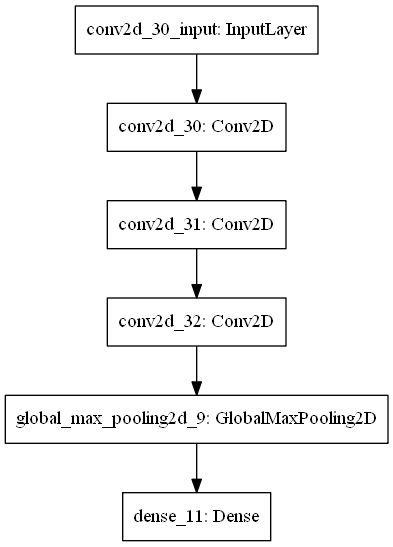

In [3]:
tf.keras.utils.plot_model(model)

In [4]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 4, 4, 4)           20        
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 3, 3, 8)           136       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 2, 2, 16)          528       
_________________________________________________________________
global_max_pooling2d_9 (Glob (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                170       
Total params: 854
Trainable params: 854
Non-trainable params: 0
_________________________________________________________________


In [2]:
tf.test.is_gpu_available()

True

In [3]:
WIDTH = 5
HEIGHT = 5

with open("data.txt") as f:
    t = f.read()

xs = []
ys = []

for ex in t.split("\n\n"):
    lines = ex.split("\n")
    y  = int(lines[0])
    x = np.array([[0 if x == "." else 1 for x in line] for line in lines[1:]])
    
    ex_width = np.max(np.arange(1, WIDTH + 1) * x)
    ex_height = np.max((np.arange(1, HEIGHT + 1) * x.T).T)
    print(y, ex_width, ex_height, end="")
    for offset_x, offset_y in itertools.product(range(WIDTH - ex_width + 1),
                                                range(HEIGHT - ex_height + 1)):
        xs.append(np.roll(x, (offset_y, offset_x), axis=(0, 1)))
        ys.append(y)
        print(".", end="")
    print()

xs = np.array(xs).astype(float)[..., np.newaxis]
ys = np.array(ys)

0 3 3.........
0 3 3.........
0 4 4....
0 3 4......
0 3 4......
0 3 4......
0 3 5...
0 4 4....
0 4 5..
0 4 4....
0 4 5..
0 5 5.
1 1 5.....
1 1 4..........
1 1 3...............
1 3 3.........
1 2 4........
1 3 4......
1 3 4......
1 3 5...
1 3 4......
1 3 4......
2 5 5.
2 3 3.........
2 3 5...
2 5 5.
2 4 5..
2 5 5.
2 5 5.
2 5 5.
2 3 4......
2 3 4......
2 3 5...
2 3 4......
3 3 3.........
3 4 5..
3 4 5..
3 4 5..
3 5 5.
3 3 5...
3 5 5.
3 5 5.
3 4 5..
3 3 5...
3 4 5..
3 4 5..
3 3 3.........
3 3 4......
3 3 4......
4 4 5..
4 4 5..
4 5 5.
4 4 5..
4 4 5..
4 3 3.........
4 4 4....
4 4 4....
4 5 5.
4 4 5..
4 3 4......
5 4 5..
5 4 5..
5 3 5...
5 3 5...
5 4 5..
5 5 5.
5 2 4........
5 3 4......
5 3 3.........
5 3 4......
5 3 4......
5 4 4....
6 3 5...
6 3 5...
6 3 3.........
6 3 5...
6 2 4........
6 3 4......
6 3 4......
6 3 4......
6 4 4....
7 3 4......
7 4 5..
7 5 5.
7 5 5.
7 3 4......
7 3 3.........
7 4 4....
7 5 5.
7 5 5.
8 3 4......
8 3 4......
8 3 4......
8 3 3.........
8 4 4....
8 4 4....
8 

In [4]:
pd.Series(ys).value_counts()

1    74
0    56
5    52
3    51
6    48
9    45
8    44
2    40
4    35
7    31
dtype: int64

In [5]:
i = np.random.randint(0, len(ys))
print(ys[i])
print(xs[i,:,:,0].astype(int))

2
[[0 1 1 1 0]
 [0 0 1 1 0]
 [0 1 0 0 0]
 [0 1 1 1 0]
 [0 0 0 0 0]]


In [6]:
def random_flip(x: np.ndarray, xs_strings: np.ndarray):
    while True:
        x_new = x.copy()
        pos_y = np.random.randint(0, HEIGHT)
        pos_x = np.random.randint(0, WIDTH)
        x_new[pos_y, pos_x] = 1 - x_new[pos_y, pos_x]
        if x_new.tostring() not in xs_strings:
            return x_new

In [7]:
xs_strings = {x.tostring() for x in xs}

In [200]:
BATCH_SIZE = 128

ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(xs),
    tf.data.Dataset.from_tensor_slices(ys)
)).shuffle(buffer_size=len(ys)).repeat()

def augment(x) -> np.ndarray:
    if np.random.uniform() > 0.5:
        x = random_flip(x, xs_strings)
    if np.random.uniform() > 0.85:
        x = random_flip(x, xs_strings)
    if np.random.uniform() > 0.95:
        x = random_flip(x, xs_strings)
    
    return x
    

def map_fn(x, y):
    x = tf.numpy_function(func=augment , inp=[x], Tout=tf.float64)
    x.set_shape([HEIGHT, WIDTH, 1])
    return x, y

ds = ds.map(map_fn)
ds = ds.batch(BATCH_SIZE)


In [201]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(4, 2, activation="relu", padding="valid", input_shape=(WIDTH, HEIGHT, 1)),
    tf.keras.layers.Conv2D(8, 2,  activation="relu"),
    tf.keras.layers.Conv2D(16, 2,  activation="relu"),
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
])

In [202]:
sum(np.product(x.shape) for x in model.weights)

854

In [203]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0025), metrics=["accuracy"], loss=tf.keras.losses.sparse_categorical_crossentropy)

In [204]:
for i in range(50):
    model.fit(ds, epochs=100, verbose=0, steps_per_epoch=len(ys) // BATCH_SIZE)
    print(model.evaluate(xs, ys, verbose=0))

[0.8197203388735026, 0.75840336]
[0.4181634628472208, 0.9117647]
[0.2612211801925627, 0.960084]
[0.19645728584097213, 0.9747899]
[0.16659380032234833, 0.9747899]
[0.151550394396822, 0.97899157]
[0.1213485473344306, 0.9873949]
[0.11772868563147153, 0.9852941]
[0.11513295431597893, 0.9831933]
[0.0985428471775616, 0.9873949]
[0.09250037015235725, 0.9873949]
[0.088900471184434, 0.9852941]
[0.09327769298262957, 0.9873949]
[0.09198501180200015, 0.9852941]
[0.08361439851402235, 0.9894958]
[0.08341239946855217, 0.9873949]
[0.07687666010455925, 0.9873949]
[0.07252179812483427, 0.99369746]
[0.07710030493365616, 0.9894958]
[0.07276230292911288, 0.9894958]
[0.06548057546635636, 0.9957983]
[0.0631654715525503, 0.9978992]
[0.0638414748451289, 0.99369746]
[0.05760382053230991, 0.9978992]
[0.0596880310316797, 0.9957983]
[0.05717225109829622, 1.0]
[0.0561420563608408, 1.0]
[0.05707980100722874, 0.9957983]
[0.0640675507861526, 0.99369746]
[0.053491534540007095, 0.9957983]
[0.05317273634258939, 0.9957983

In [189]:
model.optimizer.learning_rate.assign(0.00025)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.00025>

In [199]:
model.evaluate(ds, steps=len(ys) // BATCH_SIZE)

3/3 [==============================] - 0s 18ms/step - loss: 0.3958 - accuracy: 0.8672


[0.3958042462666829, 0.8671875]

In [134]:
model.fit(ds, epochs=100, verbose=0, steps_per_epoch=len(ys) // BATCH_SIZE)
print(model.evaluate(xs, ys, verbose=0))

[0.03486493881009206, 1.0]


In [178]:
model.save("5x5_4-8-16_filters.savedmodel")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: 5x5_4-8-16_filters.savedmodel\assets


In [176]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 4, 4, 4)           20        
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 3, 3, 8)           136       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 2, 2, 16)          528       
_________________________________________________________________
global_max_pooling2d_9 (Glob (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                170       
Total params: 854
Trainable params: 854
Non-trainable params: 0
_________________________________________________________________


In [154]:
x = np.array([
    [0,1,0,0,1],
    [1,0,1,0,0],
    [1,1,1,0,0],
    [1,0,1,0,1],
    [1,1,1,0,0]
]).astype(np.float32)[np.newaxis, ...,np.newaxis]

In [155]:
model(x)

<tf.Tensor: id=1652252, shape=(1, 10), dtype=float32, numpy=
array([[5.0382297e-02, 5.8336311e-04, 6.4316679e-05, 1.6228270e-04,
        4.1688479e-02, 4.3368284e-04, 1.5032527e-01, 3.4792183e-08,
        7.4994230e-01, 6.4179059e-03]], dtype=float32)>

In [159]:
model.layers

In [160]:
model.layers[0](x)

<tf.Tensor: id=1652306, shape=(1, 4, 4, 4), dtype=float32, numpy=
array([[[[0.502618  , 0.        , 1.8023715 , 1.917316  ],
         [0.79793376, 1.7102393 , 1.1851742 , 0.        ],
         [0.        , 0.05212986, 1.5669594 , 0.9467094 ],
         [1.0418813 , 0.        , 0.14185338, 1.5535313 ]],

        [[0.2586705 , 2.0726733 , 2.8456922 , 0.        ],
         [1.3053567 , 0.        , 3.1330698 , 1.6224971 ],
         [0.        , 1.9718777 , 1.5149939 , 0.        ],
         [0.        , 0.        , 0.        , 0.5829247 ]],

        [[1.3856957 , 0.5628624 , 1.750406  , 0.61326325],
         [2.7276978 , 0.30122414, 1.4205863 , 0.        ],
         [0.        , 1.9718777 , 1.5149939 , 0.        ],
         [0.        , 0.        , 1.2371397 , 0.28810582]],

        [[0.2586705 , 2.0726733 , 2.8456922 , 0.        ],
         [1.3053567 , 0.        , 3.1330698 , 1.6224971 ],
         [0.        , 1.9718777 , 1.5149939 , 0.        ],
         [1.0418813 , 0.        , 0.1418533

In [161]:
model.layers[1](model.layers[0](x))

<tf.Tensor: id=1652317, shape=(1, 3, 3, 8), dtype=float32, numpy=
array([[[[0.        , 0.        , 2.8644028 , 4.9411073 , 1.0166321 ,
          0.        , 7.4212365 , 0.        ],
         [0.        , 0.        , 0.        , 2.1408947 , 1.722722  ,
          2.4579952 , 2.9874277 , 0.        ],
         [0.17738095, 0.        , 0.        , 3.4742367 , 1.04086   ,
          0.        , 2.5325642 , 1.6461351 ]],

        [[3.1199167 , 1.1816763 , 2.1424901 , 4.731507  , 0.        ,
          0.04994825, 7.7961545 , 1.6499076 ],
         [1.5423524 , 2.1515965 , 0.        , 1.7521011 , 0.        ,
          0.        , 3.4096007 , 0.        ],
         [0.        , 0.        , 0.        , 6.185231  , 3.4537354 ,
          0.        , 1.4450966 , 0.6039964 ]],

        [[1.1266732 , 0.        , 6.0501323 , 3.9511342 , 2.397085  ,
          0.        , 9.643051  , 0.9603061 ],
         [0.        , 0.        , 0.        , 0.        , 0.5012328 ,
          1.7871604 , 4.2222834 , 0.     

In [162]:
model.layers[2](model.layers[1](model.layers[0](x)))

<tf.Tensor: id=1652333, shape=(1, 2, 2, 16), dtype=float32, numpy=
array([[[[11.998928  ,  2.5019045 ,  0.        ,  6.808212  ,
           0.        ,  2.2446918 ,  0.93934906,  3.123773  ,
           8.206035  ,  6.8971405 ,  0.        ,  0.        ,
           7.5184255 ,  0.        ,  0.        ,  6.0454826 ],
         [ 0.        ,  0.        ,  0.        ,  1.0777555 ,
           0.        ,  2.9489107 ,  0.        ,  0.        ,
           3.60769   ,  2.024139  ,  0.        ,  0.        ,
           0.06610802,  0.        ,  2.014959  ,  0.        ]],

        [[ 9.626691  ,  0.        ,  3.5938735 ,  9.217345  ,
           1.207052  ,  2.0163736 ,  0.        ,  3.8219762 ,
           9.965364  ,  9.481217  ,  0.        ,  0.52649593,
           8.964781  ,  0.        ,  0.        ,  5.3964696 ],
         [ 0.        ,  0.        ,  2.0928776 ,  1.2926772 ,
           0.        ,  3.5164688 ,  0.        ,  0.        ,
           3.853125  ,  0.27899772,  0.        ,  0.        

In [163]:
model.layers[3](model.layers[2](model.layers[1](model.layers[0](x))))

<tf.Tensor: id=1652351, shape=(1, 16), dtype=float32, numpy=
array([[11.998928  ,  2.5019045 ,  3.5938735 ,  9.217345  ,  1.207052  ,
         3.5164688 ,  0.93934906,  3.8219762 ,  9.965364  ,  9.481217  ,
         0.        ,  0.52649593,  8.964781  ,  0.32882565,  3.568447  ,
         6.0454826 ]], dtype=float32)>